In [29]:
using LinearAlgebra, Plots, DataFrames, Statistics, CSV, Polynomials, TaylorSeries

## Zadanie 1
**(1pkt)** Uruchomić 
   - `naive_multiplication(A,B)`, 
   - `better_multiplication(A,B)` 
   - mnożenie BLAS w Julii (`A*B`) 

dla coraz większych macierzy kwadratowych i zmierzyć czasy. Narysować wykres zależności czasu od rozmiaru macierzy wraz z słupkami błędów. Wszystkie trzy metody powinny być na jednym wykresie. Do analizy danych można użyć wybranego narzędzia (Julia, R)

#### Metody mnożenia macierzy

In [30]:
function naive_multiplication(A,B)
    C = zeros(Float64, size(A,1), size(B,2))
    for i=1:size(A,1)
        for j=1:size(B,2)
            for k=1:size(A,2)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

function better_multiplication(A, B)
    C = zeros(Float64, size(A,1), size(B,2))
    for j=1:size(B,2)
        for k=1:size(A,2)
            for i=1:size(A,1)
                C[i,j] = C[i,j] + A[i,k]*B[k,j]
            end
        end
    end
    C
end

Asmall = [[1.0 4.0]; [0.0 1.0]]
Bsmall = Asmall
naive_multiplication(Asmall,Bsmall)
better_multiplication(Asmall,Bsmall)
Asmall * Bsmall #blass

2×2 Matrix{Float64}:
 1.0  8.0
 0.0  1.0

#### Pomiar czasu działania porównywanych metod

In [31]:
stats = DataFrame(Size=Int[], Type=String[], Time=Float64[])
for i in 100:100:1000
    matrix1 = rand(0:9,(i,i))
    matrix2 = rand(0:9,(i,i))
    for j in 1:5
        _, time1 = @timed naive_multiplication(matrix1,matrix2)
        _, time2 = @timed better_multiplication(matrix1,matrix2)
        _, time3 = @timed matrix1*matrix2
        push!(stats,(i, "naive", time1))
        push!(stats,(i, "better", time2))
        push!(stats,(i, "blas", time3))
    end
end

statsCombined = combine(groupby(stats, [:Size, :Type]), :Time => mean, :Time => std)

Row,Size,Type,Time_mean,Time_std
,Int64,String,Float64,Float64
1,100,naive,0.00269048,4.86285e-6
2,100,better,0.000832703,0.00022481
3,100,blas,0.000261234,2.03804e-5
4,200,naive,0.0225108,5.9973e-5
5,200,better,0.00526831,0.000477944
6,200,blas,0.00193231,2.73888e-5
7,300,naive,0.076721,0.000128805
8,300,better,0.0164283,0.000460419
9,300,blas,0.0065912,9.69522e-5


#### Wykres porównania czasów mnożenia macierzy

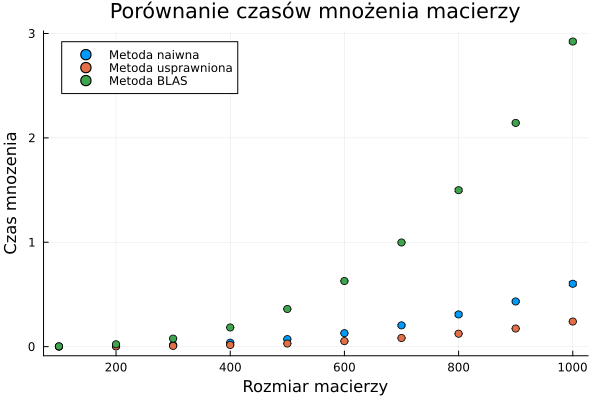

In [32]:
scatter(
    statsCombined[!,:Size], 
    statsCombined[!,:Time_mean], 
    group=statsCombined[!,:Type], 
    yerr=statsCombined[!,:Time_std],
    xlabel="Rozmiar macierzy",
    ylabel="Czas mnozenia",
    title="Porównanie czasów mnożenia macierzy",
    label=["Metoda naiwna" "Metoda usprawniona" "Metoda BLAS"])

## Zadanie 2
**(2 pkt)** Napisać w języku C:
   - naiwną metodę mnożenia macierzy kwadratowych (wersja 1) 
   - ulepszoną wersję za pomocą zamiany pętli metodę mnożenia macierzy (wersja 2), pamiętając, że w C macierz przechowywana jest wierszami (row major order tzn A11,A12, ..., A1m, A21, A22,...,A2m, ..Anm), inaczej niż w Julii ! 
   - skorzystać z  możliwości BLAS poziom 3 dostępnego w GSL  (przykład uzycia https://www.gnu.org/software/gsl/doc/html/blas.html#examples )

Należy porównywać działanie tych trzech algorytmow bez włączonej opcji optymalizacji kompilatora. Przedstawić wyniki na jednym wykresie tak jak w p.1. (osobno niż p.1). 
Do analizy danych można użyć wybranego narzędzia (Julia, R)
*(Dla chętnych)* sprawdzić, co się dzieje, jak włączymy optymalizację kompilatora i dodać do wykresu. 

#### Kod w języku C
``` C
#include <stdio.h>
#include <stdlib.h>
#include <time.h>
#include <gsl/gsl_blas.h>

// naiwna metoda mnożenia macierzy kwadratowych
void naive_multiplication(double *A, double *B, double *C, int n)
{
    for (int i = 0; i < n; i++)
    {
        for (int j = 0; j < n; j++)
        {
            C[i * n + j] = 0.0;
            for (int k = 0; k < n; k++)
            {
                C[i * n + j] += A[i * n + k] * B[k * n + j];
            }
        }
    }
}

// ulepszona metoda mnożenia macierzy kwadratowych
void better_multiplication(double *A, double *B, double *C, int n)
{
    for (int i = 0; i < n; i++)
    {
        for (int k = 0; k < n; k++)
        {
            double r = A[i * n + k];
            for (int j = 0; j < n; j++)
            {
                C[i * n + j] += r * B[k * n + j];
            }
        }
    }
}

// funkcja do pomiaru czasu
double get_time()
{
    return (double)clock() / CLOCKS_PER_SEC;
}

// główna funkcja
int main()
{
    double *A, *B, *C, *D;
    double t1, t2, t3;

    printf("n,type,time\n");
    for (int n = 100; n < 1001; n += 100)
    {
        A = (double *)malloc(n * n * sizeof(double));
        B = (double *)malloc(n * n * sizeof(double));
        C = (double *)malloc(n * n * sizeof(double));
        D = (double *)malloc(n * n * sizeof(double));

        for (int j = 0; j < n * n; j++)
        {
            A[j] = ((double)rand() / RAND_MAX) * 10.0;
            B[j] = ((double)rand() / RAND_MAX) * 10.0;
            C[j] = 0.0;
            D[j] = 0.0;
        }

        for (int i = 0; i < 5; i++)
        {

            t1 = get_time();
            naive_multiplication(A, B, C, n);
            t1 = get_time() - t1;

            printf("%d,%s,%f\n", n, "naive", t1);

            t2 = get_time();
            better_multiplication(A, B, D, n);
            t2 = get_time() - t2;

            printf("%d,%s,%f\n", n, "better", t2);

            gsl_matrix_view a = gsl_matrix_view_array(A, n, n);
            gsl_matrix_view b = gsl_matrix_view_array(B, n, n);
            gsl_matrix_view d = gsl_matrix_view_array(D, n, n);

            t3 = get_time();
            gsl_blas_dgemm(CblasNoTrans, CblasNoTrans, 1.0, &a.matrix, &b.matrix, 0.0, &d.matrix);
            t3 = get_time() - t3;

            printf("%d,%s,%f\n", n, "BLAS", t3);
        }

        free(A);
        free(B);
        free(C);
        free(D);
    }

    return 0;
}

```

#### Analiza wyników

In [33]:
results = CSV.read("results.txt", delim=",", DataFrame)

resultsCombined = combine(groupby(results, [:n, :type]), :time => mean, :time => std)
rename!(resultsCombined, 
        ["Size", "Type", "Time_mean", "Time_std"])

Row,Size,Type,Time_mean,Time_std
,Int64,String7,Float64,Float64
1,100,naive,0.003306,0.000241752
2,100,better,0.0027672,0.000101547
3,100,BLAS,0.0003646,5.85132e-5
4,200,naive,0.0258074,0.000564123
5,200,better,0.0217316,0.000345512
6,200,BLAS,0.0024836,0.000103676
7,300,naive,0.0864606,0.00369811
8,300,better,0.0722862,0.00521545
9,300,BLAS,0.0086922,0.00140552


#### Wykres porównania mnożenia macierzy w języku C

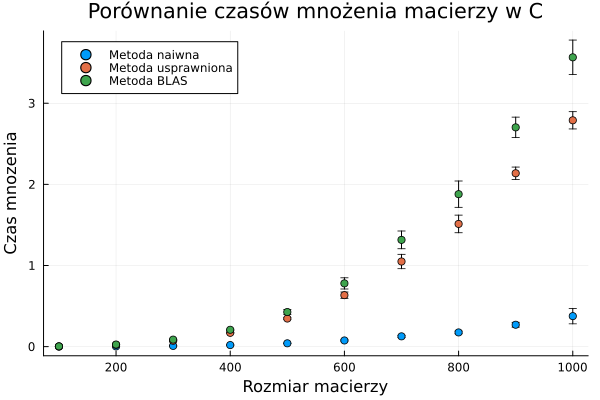

In [34]:
scatter(
    resultsCombined[!,:Size], 
    resultsCombined[!,:Time_mean], 
    group=resultsCombined[!,:Type], 
    yerr=resultsCombined[!,:Time_std],
    xlabel="Rozmiar macierzy",
    ylabel="Czas mnozenia",
    title="Porównanie czasów mnożenia macierzy w C",
    label=["Metoda naiwna" "Metoda usprawniona" "Metoda BLAS"])


## Zadanie 3
**(1 pkt)** Użyć aproksymacji odpowiednimi wielomianami, które najlepiej pasują do zależności czasowych każdego z algorytmów. Stopień wielomianu powinien zgadzać się z teoretyczną złożonoscią. Dodać wykresy uzyskanych wielomianów do wcześniejszych wykresów. Do analizy danych można użyć wybranego narzędzia (Julia, R)

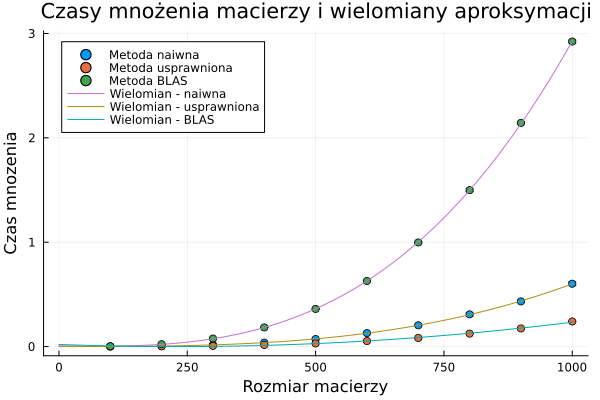

In [35]:
fit1 = fit(statsCombined[statsCombined.Type .== "naive", :Size], statsCombined[statsCombined.Type .== "naive", :Time_mean], 3)
fit2 = fit(statsCombined[statsCombined.Type .== "better", :Size], statsCombined[statsCombined.Type .== "better", :Time_mean], 3)
fit3 = fit(statsCombined[statsCombined.Type .== "blas", :Size], statsCombined[statsCombined.Type .== "blas", :Time_mean], 2)

xs = 0:1:1001
scatter(
    statsCombined[!,:Size], 
    statsCombined[!,:Time_mean], 
    group=statsCombined[!,:Type], 
    yerr=statsCombined[!,:Time_std],
    xlabel="Rozmiar macierzy",
    ylabel="Czas mnozenia",
    title="Czasy mnożenia macierzy i wielomiany aproksymacji",
    label=["Metoda naiwna" "Metoda usprawniona" "Metoda BLAS"]
    )
plot!(fit1, extrema(xs)..., label="Wielomian - naiwna")
plot!(fit2, extrema(xs)..., label="Wielomian - usprawniona")
plot!(fit3, extrema(xs)..., label="Wielomian - BLAS")

## Zadanie 4
**(1 pkt)** Pokazać zniwelowanie efektu Rungego  poprzez użycie wsparcia dla wielomianów Czebyszewa w pakiecie Polynomials. Wymagany wykres. 

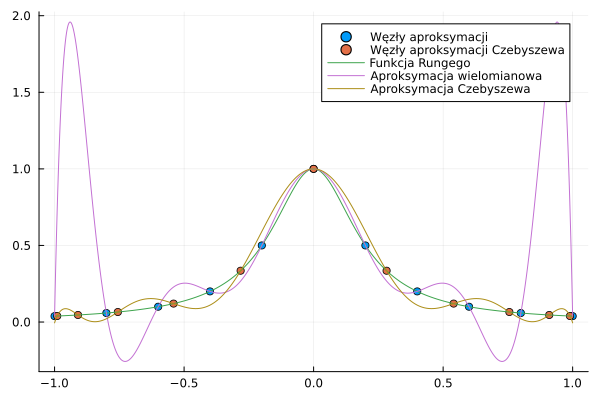

In [39]:
function runge(x)
    return 1.0 / (1.0 + 25.0 * x^2)
end

xs = range(-1, 1, length=11) #węzły aproksymacji
ys = runge.(xs)

x = range(-1, 1, length=1001)
y_runge = runge.(x)


poly_approx = fit(xs, ys, 11)
y_poly_approx = poly_approx.(x)

base = [0,0,0,0,0,0,0,0,0,0,0,1]
chebyshev = ChebyshevT(base)
x_cheb = Polynomials.roots(chebyshev)
y_cheb = runge.(x_cheb)

cheb_approx = fit(x_cheb, y_cheb, 11)
y_cheb_approx = cheb_approx.(x)

scatter(
    [xs, x_cheb],
    [ys, y_cheb],
    label=["Węzły aproksymacji" "Węzły aproksymacji Czebyszewa"]
    )

plot!(
    x,
    [y_runge, y_poly_approx, y_cheb_approx],
    label = ["Funkcja Rungego" "Aproksymacja wielomianowa" "Aproksymacja Czebyszewa"]
)

## Zadanie 5
**(1 pkt)** Przybliżenie Pade jest często lepsze niż rozwinięcie w szereg Taylora przy aproksymowaniu funkcji, które posiadają osobliwości. Korzystając ze wsparcia dla aproksymacji Pade w pakiecie Polynomials pokazać dowolny przykład (wraz z wykresem), gdzie takie przybliżenie faktycznie jest lepsze. Można odtworzyć wykres z wykładu albo zainspirować się przykładowym artykułem https://www.hindawi.com/journals/ijcm/2014/587430/ 


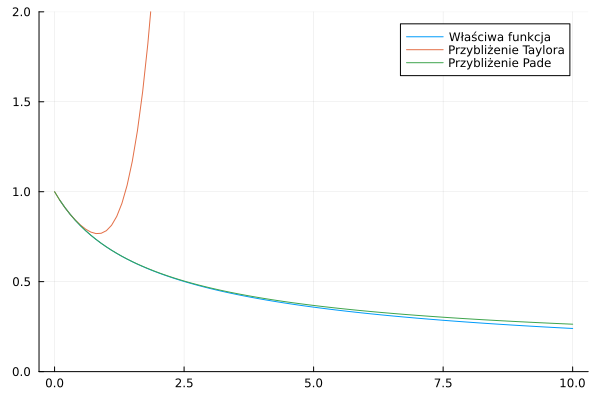

In [38]:
function f(x)
    log(1+x)/x
end

t = Taylor1(Float64, 5)
f_taylor = f(t) #rozwinięcie szeregu taylora
f_taylor_approx = Polynomial(f_taylor.coeffs)
f_pade = myfun_pade = Polynomials.PolyCompat.PadeApproximation.Pade(f_taylor_approx, 2, 2)

x = 0:0.1:10
y_f = f.(x)
y_taylor = f_taylor_approx.(x)
y_pade = f_pade.(x)

plot(
    x,
    [y_f, y_taylor, y_pade],
    ylims=[0,2],
    label = ["Właściwa funkcja" "Przybliżenie Taylora" "Przybliżenie Pade"]
)